In [1]:
from pygdsm import GlobalSkyModel2016
import healpy as hp
import numpy as np
from numpy.linalg import svd
from scipy.special import eval_legendre
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

import src.beam_functions as BF
import src.spherical_harmonics as SH
import src.forward_model as FM
import src.sky_models as SM
import src.map_making as MM
import src.plotting as PL
from src.blockmat import BlockMatrix, BlockVector
from anstey.generate import T_CMB

RS = SH.RealSphericalHarmonics()

In [2]:
nuarr = 60
lmax  = 8
nside = lmax
seed = 123
sigma = 0.0851
sigma_T = sigma * np.log(408/nuarr)

_, gsma_map = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, original_map=True)
gsma_map = gsma_map[0]
_, fg_map = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, 
                               delta=sigma, seed=seed, original_map=True)
# Generate a series of these
fg_maps = []
for i in range(500):
    _, m = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, 
                               delta=sigma, seed=seed+i, original_map=True)
    fg_maps.append(m[0])

successfully loaded spherical_harmonic_matrix npix, nalm : 768 45
successfully loaded spherical_harmonic_matrix npix, nalm : 768 45
successfully loaded spherical_harmonic_matrix npix, nalm : 768 45
successfully loaded spherical_harmonic_matrix npix, nalm : 768 45
successfully loaded spherical_harmonic_matrix npix, nalm : 768 45
successfully loaded spherical_harmonic_matrix npix, nalm : 768 45
successfully loaded spherical_harmonic_matrix npix, nalm : 768 45
successfully loaded spherical_harmonic_matrix npix, nalm : 768 45
successfully loaded spherical_harmonic_matrix npix, nalm : 768 45
successfully loaded spherical_harmonic_matrix npix, nalm : 768 45
successfully loaded spherical_harmonic_matrix npix, nalm : 768 45
successfully loaded spherical_harmonic_matrix npix, nalm : 768 45
successfully loaded spherical_harmonic_matrix npix, nalm : 768 45
successfully loaded spherical_harmonic_matrix npix, nalm : 768 45
successfully loaded spherical_harmonic_matrix npix, nalm : 768 45
successful

In [3]:
np.shape(fg_maps)

(500, 768)

In [4]:
# Calculate the mean and covariance of the error instances.
fg_samplemean = np.mean(fg_maps, axis=0)
fg_samplestd = np.std(fg_maps, axis=0)

In [5]:
sigma_T

0.16313011429669338

In [6]:
(np.exp(2*sigma_T**2)-np.exp(sigma_T**2))

0.02769599002681633

In [7]:
# Compare this to the analytic mean and covariance of the error instance distribution.
fg_analmean = (gsma_map-T_CMB)*np.exp(sigma_T**2/2) + T_CMB
fg_analcov  = (gsma_map-T_CMB)**2 * (np.exp(2*sigma_T**2)-np.exp(sigma_T**2))

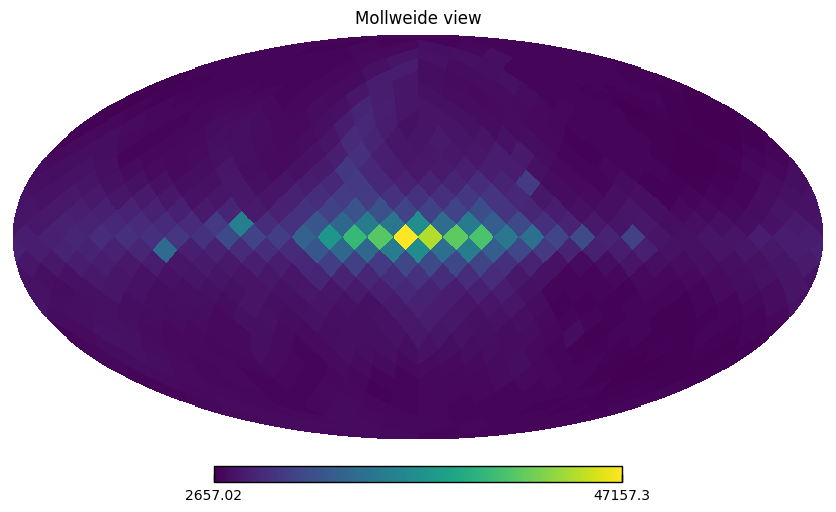

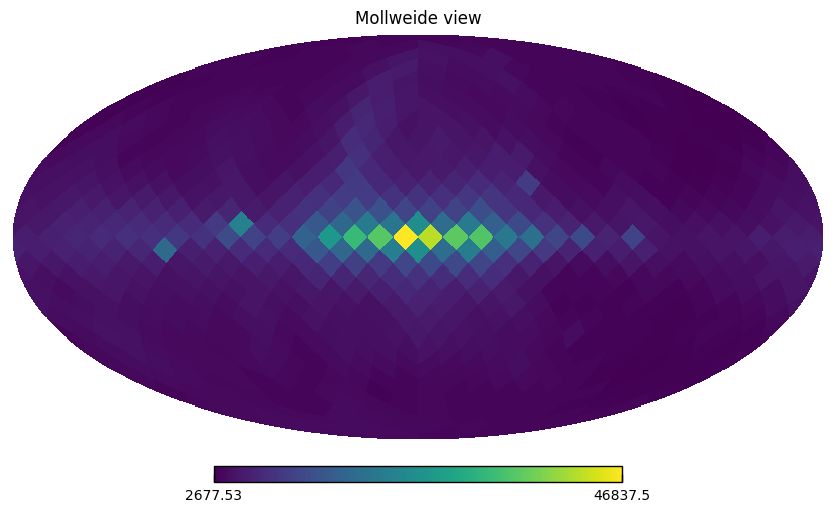

In [8]:
hp.mollview(fg_samplemean)
plt.show()
hp.mollview(fg_analmean)
plt.show()

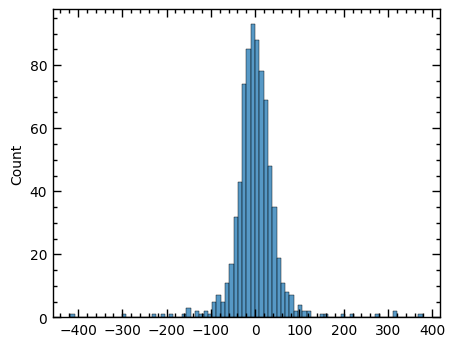

In [9]:
sns.histplot(fg_samplemean-fg_analmean)
plt.show()

<Axes: ylabel='Count'>

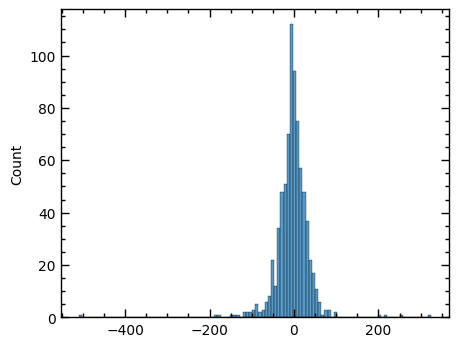

In [10]:
sns.histplot(fg_samplestd-np.sqrt(fg_analcov))

In [13]:
def get_sigma(d, mu, cov, pix='all'):
    if pix == 'all':
        return np.mean((d-mu)**2 / cov)
    return (d[pix]-mu[pix])**2 / cov[pix]


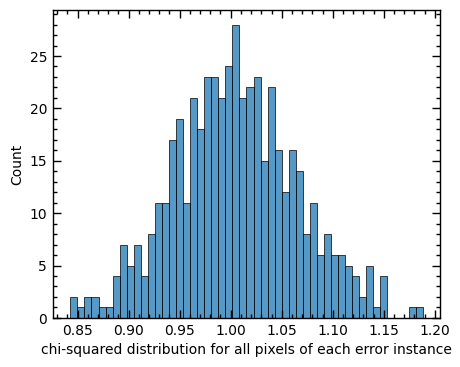

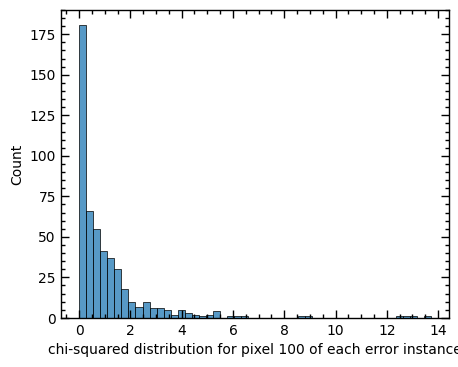

In [14]:
# Show that the distribution of sampled error instances is Gaussian?
sigmas = []
for fg_map in fg_maps:
    sigmas.append(get_sigma(fg_map, gsma_map, fg_analcov, pix='all'))
sns.histplot(sigmas, bins=50)
plt.xlabel(r"chi-squared distribution for all pixels of each error instance")
plt.show()
sigmas = []
for fg_map in fg_maps:
    sigmas.append(get_sigma(fg_map, gsma_map, fg_analcov, pix=100))
sns.histplot(sigmas, bins=50)
plt.xlabel(r"chi-squared distribution for pixel 100 of each error instance")
plt.show()

## Generate a chi-squared $\approx$ 1 foreground with nside=lmax=32

In [20]:
# Now do this stuff with the big boi nside=lmax=32
nuarr = 60
lmax  = 32
nside = lmax
seed = 123
sigma = 0.0851
sigma_T = sigma * np.log(408/nuarr)

_, gsma_map = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, original_map=True)
gsma_map = gsma_map[0]

# Generate a series of these
fg_maps = []
for i in range(50):
    _, m = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, 
                               delta=sigma, seed=seed+i, original_map=True)
    fg_maps.append(m[0])

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
successfully loaded spherical_harm

In [21]:
# Calculate the analytic mean and covariance of the error instance distribution.
fg_analmean = (gsma_map-T_CMB)*np.exp(sigma_T**2/2) + T_CMB
fg_analcov  = (gsma_map-T_CMB)**2 * (np.exp(2*sigma_T**2)-np.exp(sigma_T**2))

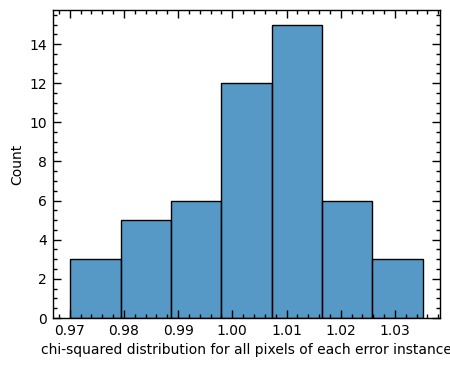

<Axes: ylabel='Count'>

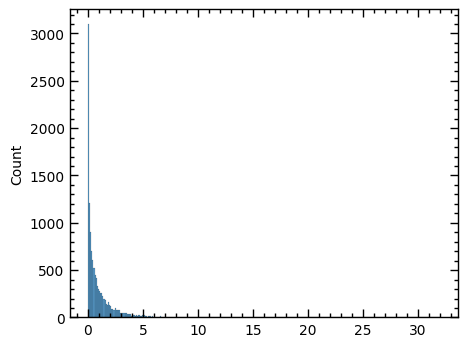

In [28]:
def get_sigma(d, mu, cov, pix='all'):
    if pix == 'all':
        return np.mean((d-mu)**2 / cov)
    if pix=='single':
        return (d-mu)**2 / cov
    return (d[pix]-mu[pix])**2 / cov[pix]

sigmas = []
for fg_map in fg_maps:
    sigmas.append(get_sigma(fg_map, gsma_map, fg_analcov, pix='all'))
sns.histplot(sigmas)
plt.xlabel(r"chi-squared distribution for all pixels of each error instance")
plt.show()

sns.histplot(get_sigma(fg_maps[0], gsma_map, fg_analcov, pix='single'))

In [26]:
# Pick the closest to 1 and save it.
sigmas

[1.0124632746649593,
 0.9821432444043684,
 0.9946765657118631,
 1.0184605270872735,
 1.0062254059430555,
 0.9867771999625949,
 1.008360609546087,
 1.0038641442323615,
 1.0126326105288486,
 1.0140909630053796,
 1.0082203802057947,
 1.0011602333965395,
 0.9928835171381195,
 0.9833824339040436,
 1.0191528230826534,
 1.0177705989130474,
 1.012580775473903,
 0.9927479896494943,
 0.999709773893034,
 1.005272753592591,
 1.035100546217661,
 1.0108929852674937,
 1.0063820648006552,
 1.004941887031461,
 1.0041551625841685,
 0.9855991205503306,
 1.024514678886494,
 1.009274862515051,
 1.003723649145443,
 1.021513658844083,
 1.0107699091078413,
 0.9889848799913091,
 1.0132198485496353,
 1.013859214259562,
 0.9824052619876583,
 1.0165050851384836,
 1.032553393518367,
 1.0059406077109527,
 0.9969365188899243,
 0.9996485632614595,
 1.0006980130123555,
 1.0078910651054844,
 1.009404261250915,
 0.979103694303479,
 1.0128924825948389,
 1.0310809292289513,
 0.9944962261823803,
 0.9701278434547005,
 1.022